In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iqothnccd-lung-cancer-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1748489%2F2882784%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241008%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241008T134326Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D61220741e2e75582e43e6f88bc9e304406f8ab6a401e4ff535b78761e9b636a5aa484ab72cceb3cb3ac467ecc007b9511adf95393c6251d61288fc98d722a36aa2ce66525140f6745f42ff8116d4f2bf480b518e2ad5af145b4c66752a709b4165a78cde32702d5cf324ffa65862b7b1ba5d862a644c0bf9ef7e099f4d8411748b7a39ff95b5057a74a145cd6ec57aaf10a8ae62ed0fa65d7011bbdbfcf218f72b38f6154b3b1e3c764aad51736afe04e106bb1b27f62894de7dec4601b3c50f6f827181c6465f7320a069b48fc46779e730e1e390eefaf4573955b4bae08002fa5ca6e3c9855bcfe20a3f86628ab9dd66589f6298709e2ba6c2542b959d423e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 208562220 bytes downloaded
Downloaded and uncompressed: iqothnccd-lung-cancer-dataset
Data source import complete.


In [3]:
# !pip install tensorflow==2.12.0 # Install a compatible TensorFlow version
# !pip install tensorflow-addons==0.19.0 # Install the specified version of TensorFlow Addons
# !pip install keras==2.12.0 # Install a compatible Keras version

%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # Import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa # After re-installation of tensorflow_addons, import should work
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.utils import load_img, img_to_array, array_to_img # Import load_img, img_to_array, and array_to_img from tensorflow.keras.utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator from tensorflow.keras.preprocessing.image

In [22]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [4]:
directory = '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [5]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

<ipython-input-5-3269ec0e3dbe>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '512 x 623': 31,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


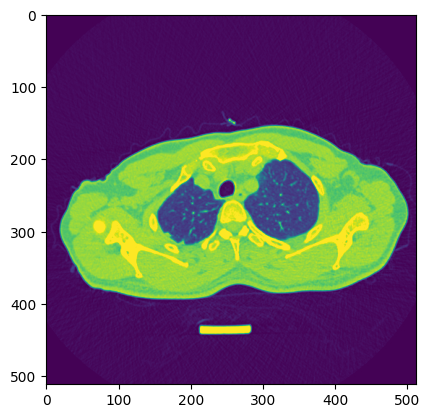

Malignant cases


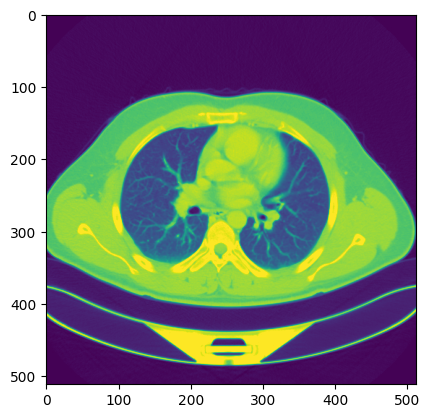

Normal cases


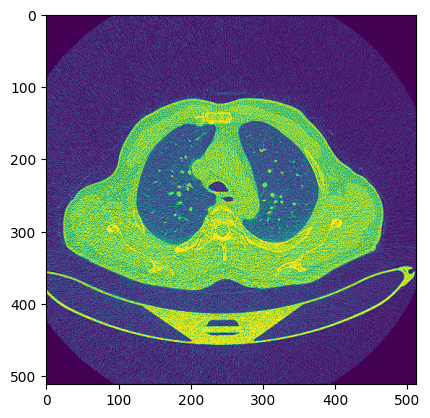

In [6]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

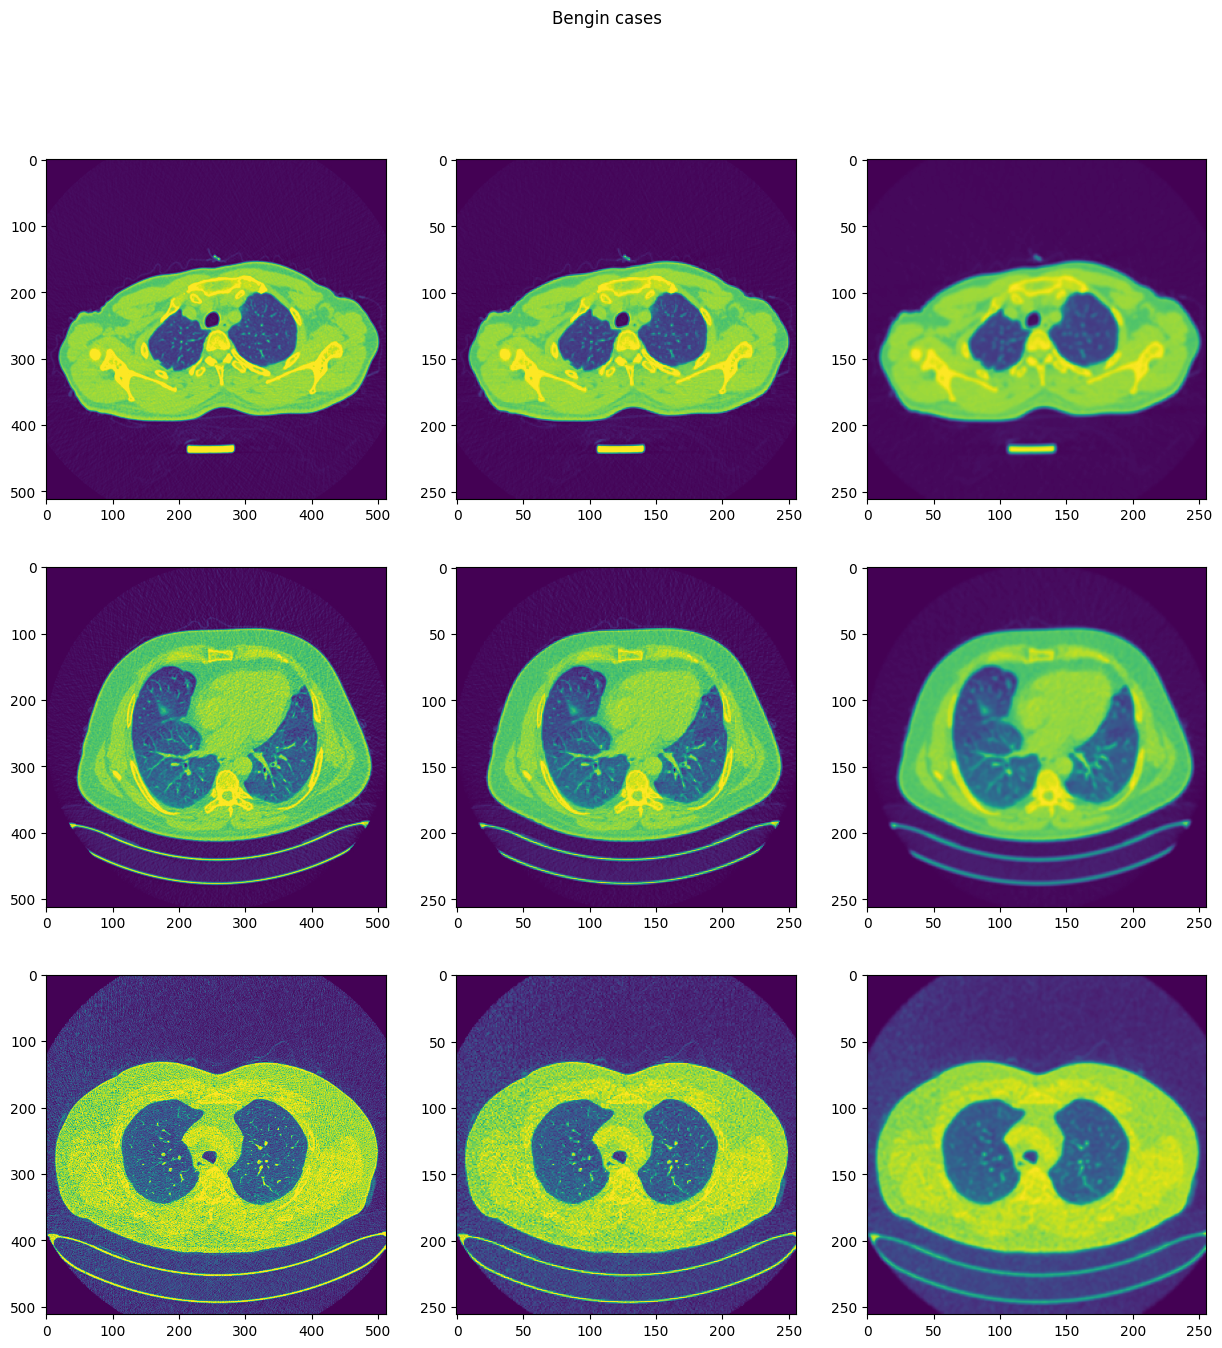

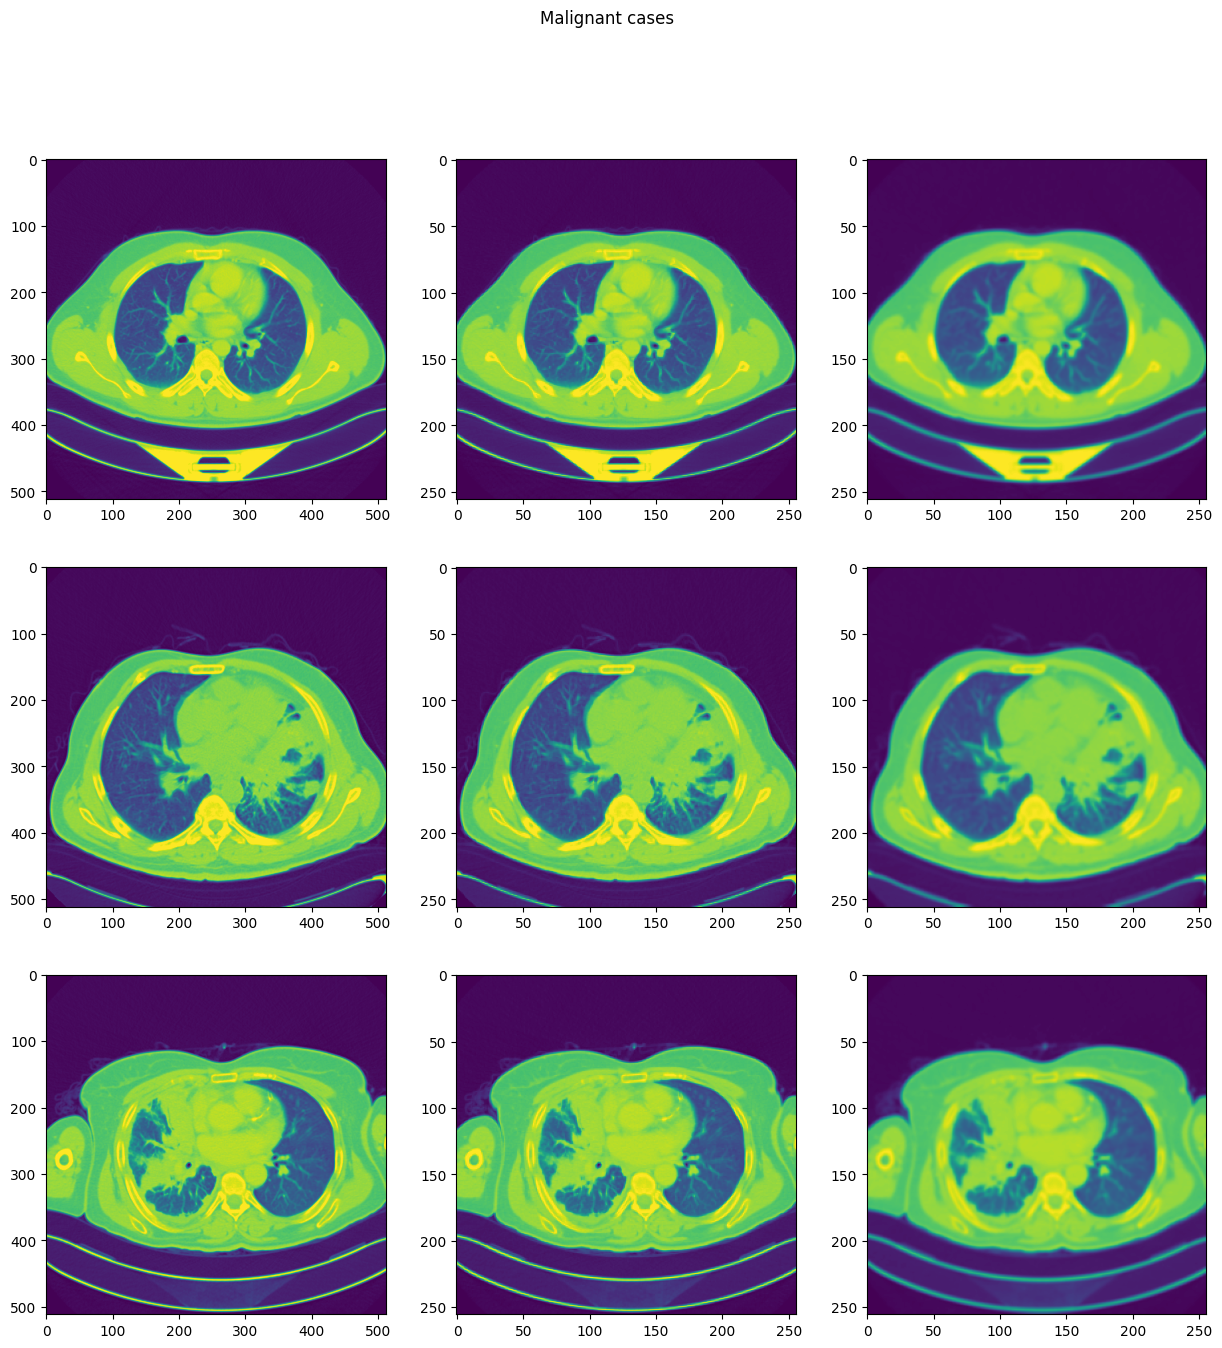

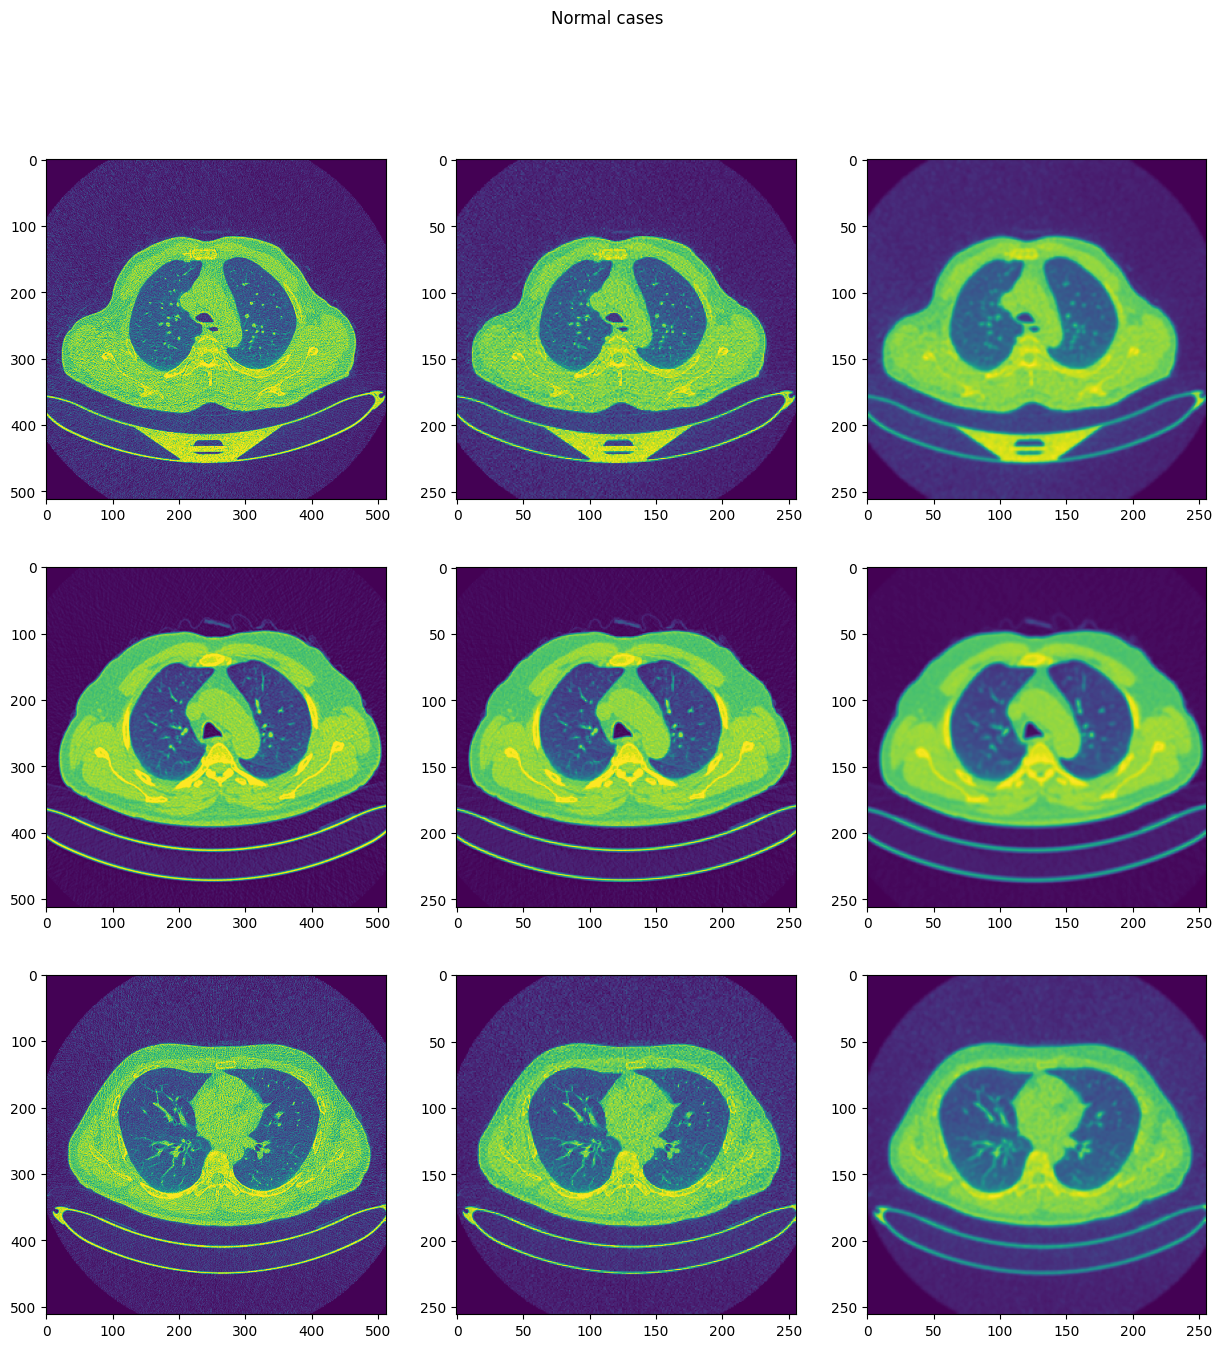

In [7]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()

In [8]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


In [10]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [11]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [12]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [13]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


In [14]:
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(16))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      640       
                                                                 
 activation (Activation)     (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0

In [15]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model1.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=7, validation_data=(X_valid, y_valid))

Epoch 1/7
158/158 [==============================] - 270s 2s/step - loss: 0.1029 - accuracy: 0.9698 - val_loss: 0.1040 - val_accuracy: 0.9636
Epoch 2/7
158/158 [==============================] - 272s 2s/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.1515 - val_accuracy: 0.9564
Epoch 3/7
158/158 [==============================] - 300s 2s/step - loss: 0.0122 - accuracy: 0.9992 - val_loss: 0.0784 - val_accuracy: 0.9855
Epoch 4/7
158/158 [==============================] - 284s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1220 - val_accuracy: 0.9818
Epoch 5/7
158/158 [==============================] - 269s 2s/step - loss: 0.0203 - accuracy: 0.9944 - val_loss: 0.0689 - val_accuracy: 0.9818
Epoch 6/7
158/158 [==============================] - 270s 2s/step - loss: 0.0249 - accuracy: 0.9952 - val_loss: 0.0483 - val_accuracy: 0.9855
Epoch 7/7
158/158 [==============================] - 269s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0556 - val_accuracy: 0.9855


In [19]:
y_pred = model1.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 26s 3s/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       1.00      0.99      1.00       141
           2       0.98      0.98      0.98       104

    accuracy                           0.99       275
   macro avg       0.97      0.98      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 29   0   1]
 [  0 140   1]
 [  2   0 102]]


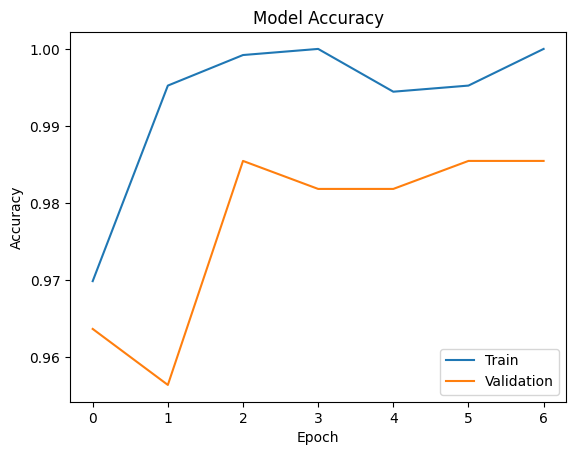

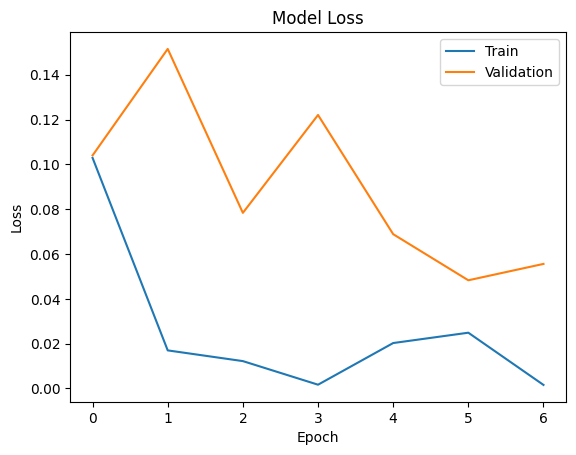

In [20]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(16))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_1 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)           

In [22]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [25]:
history = model2.fit(X_train, y_train, batch_size=8, epochs=7, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/7
103/103 [==============================] - 188s 2s/step - loss: 0.6302 - accuracy: 0.7616 - val_loss: 0.2296 - val_accuracy: 0.9055
Epoch 2/7
103/103 [==============================] - 184s 2s/step - loss: 0.0730 - accuracy: 0.9781 - val_loss: 0.1174 - val_accuracy: 0.9600
Epoch 3/7
103/103 [==============================] - 182s 2s/step - loss: 0.0640 - accuracy: 0.9927 - val_loss: 0.0778 - val_accuracy: 0.9673
Epoch 4/7
103/103 [==============================] - 176s 2s/step - loss: 0.0129 - accuracy: 0.9964 - val_loss: 0.0720 - val_accuracy: 0.9745
Epoch 5/7
103/103 [==============================] - 174s 2s/step - loss: 0.0384 - accuracy: 0.9939 - val_loss: 0.0664 - val_accuracy: 0.9782
Epoch 6/7
103/103 [==============================] - 183s 2s/step - loss: 0.0075 - accuracy: 0.9988 - val_loss: 0.1659 - val_accuracy: 0.9745
Epoch 7/7
103/103 [==============================] - 182s 2s/step - loss: 0.1296 - accuracy: 0.9684 - val_loss: 0.0722 - val_accuracy: 0.9855


In [26]:
y_pred = model2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 35s 4s/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.99      1.00      1.00       141
           2       0.99      0.97      0.98       104

    accuracy                           0.99       275
   macro avg       0.97      0.98      0.98       275
weighted avg       0.99      0.99      0.99       275

[[ 29   0   1]
 [  0 141   0]
 [  2   1 101]]


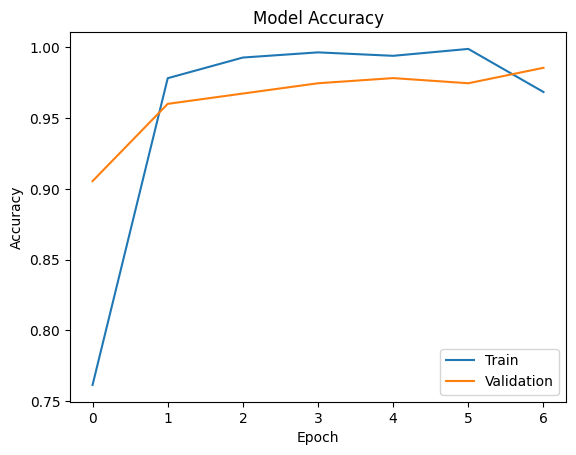

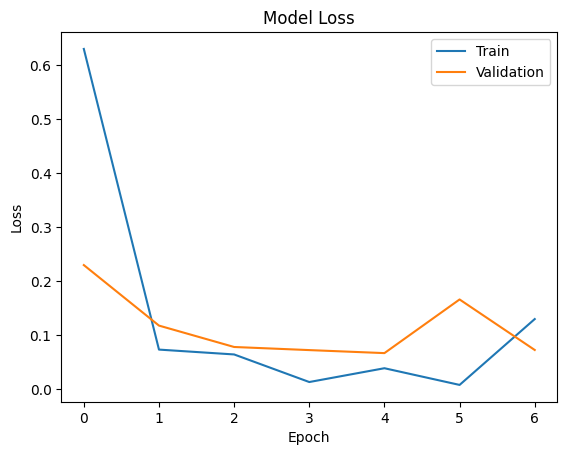

In [27]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [28]:
model2.save('lungmodel.h5')

In [29]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
val_datagen = ImageDataGenerator()

In [30]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [31]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(16))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 activation_2 (Activation)   (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 246016)           

In [32]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)

<ipython-input-33-6ec88e3e8198>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator, epochs=5, validation_data=val_generator, class_weight=new_weights)


Epoch 1/5
103/103 [==============================] - 181s 2s/step - loss: 1.0587 - accuracy: 0.5876 - val_loss: 0.6387 - val_accuracy: 0.7236
Epoch 2/5
103/103 [==============================] - 178s 2s/step - loss: 0.6150 - accuracy: 0.7603 - val_loss: 0.4477 - val_accuracy: 0.8218
Epoch 3/5
103/103 [==============================] - 193s 2s/step - loss: 0.3381 - accuracy: 0.8808 - val_loss: 0.2236 - val_accuracy: 0.9345
Epoch 4/5
103/103 [==============================] - 197s 2s/step - loss: 0.2017 - accuracy: 0.9428 - val_loss: 0.1816 - val_accuracy: 0.9527
Epoch 5/5
103/103 [==============================] - 196s 2s/step - loss: 0.1097 - accuracy: 0.9599 - val_loss: 0.1636 - val_accuracy: 0.9564


In [34]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 16s 2s/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.99      0.99      0.99       141
           2       0.94      0.94      0.94       104

    accuracy                           0.96       275
   macro avg       0.93      0.93      0.93       275
weighted avg       0.96      0.96      0.96       275

[[ 26   0   4]
 [  0 139   2]
 [  4   2  98]]
